In [1]:
cd ..

/home/pierre/git/semisupervised


This problem has the following inputs:
1. Frequency, in Hertzs.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:

6. Scaled sound pressure level, in decibels.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import gpytorch
import torch

/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
x = np.loadtxt('data/airfoil_self_noise.dat')
scale= StandardScaler()
scaled_data = scale.fit_transform(x)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.double
train_x = scaled_data[:, :5]
train_x = torch.tensor(train_x, dtype=dtype, device=device)
train_y = scaled_data[:, 5]
train_y = torch.tensor(train_y, dtype=dtype, device=device)

torch.save(train_x, 'train_x.pt')
torch.save(train_y, 'train_y.pt')


In [7]:
n = train_x.shape[0]
noises = torch.ones(n, dtype=dtype, device=device) * 1e-5
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noises)
model = ExactGPModel(train_x, train_y, likelihood).to(dtype=dtype, device=device)

In [8]:
training_iter = 500
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item()
        #model.likelihood.noise.item()
    ))
    optimizer.step()

/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 5.4534970168203465 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/500 - Loss: 859.204   lengthscale: 0.693


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.69035428799453 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 2/500 - Loss: 780.513   lengthscale: 0.644


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.9533868478242775 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 3/500 - Loss: 706.192   lengthscale: 0.598


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.1862662707445715 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 4/500 - Loss: 635.464   lengthscale: 0.554


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.7954143166050587 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 5/500 - Loss: 577.860   lengthscale: 0.513


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.222508448974724 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 6/500 - Loss: 507.193   lengthscale: 0.474


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.286597343279424 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 7/500 - Loss: 460.294   lengthscale: 0.438


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.180340655291218 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 8/500 - Loss: 409.967   lengthscale: 0.404


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.0654690222165017 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 9/500 - Loss: 340.665   lengthscale: 0.373


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.080368840477506 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 10/500 - Loss: 311.564   lengthscale: 0.345


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.384061021514938 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 11/500 - Loss: 274.010   lengthscale: 0.319


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.529286362823581 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 12/500 - Loss: 228.785   lengthscale: 0.295


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.7895739152711214 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 13/500 - Loss: 197.225   lengthscale: 0.274


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.528117105980293 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 14/500 - Loss: 169.160   lengthscale: 0.254


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8150596063826092 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 15/500 - Loss: 140.819   lengthscale: 0.237


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.0933788897038195 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 16/500 - Loss: 119.720   lengthscale: 0.221


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.7561017813506261 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 17/500 - Loss: 101.985   lengthscale: 0.206


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.713275109553595 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 18/500 - Loss: 86.701   lengthscale: 0.193


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8492727119183496 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 19/500 - Loss: 72.683   lengthscale: 0.182
Iter 20/500 - Loss: 61.658   lengthscale: 0.171
Iter 21/500 - Loss: 52.845   lengthscale: 0.162
Iter 22/500 - Loss: 46.073   lengthscale: 0.154
Iter 23/500 - Loss: 40.585   lengthscale: 0.146
Iter 24/500 - Loss: 34.583   lengthscale: 0.140
Iter 25/500 - Loss: 29.416   lengthscale: 0.133
Iter 26/500 - Loss: 27.336   lengthscale: 0.128
Iter 27/500 - Loss: 24.214   lengthscale: 0.123
Iter 28/500 - Loss: 21.571   lengthscale: 0.118
Iter 29/500 - Loss: 19.400   lengthscale: 0.114
Iter 30/500 - Loss: 17.401   lengthscale: 0.111
Iter 31/500 - Loss: 15.364   lengthscale: 0.107
Iter 32/500 - Loss: 14.447   lengthscale: 0.104
Iter 33/500 - Loss: 13.399   lengthscale: 0.101
Iter 34/500 - Loss: 10.982   lengthscale: 0.099
Iter 35/500 - Loss: 9.536   lengthscale: 0.096
Iter 36/500 - Loss: 10.038   lengthscale: 0.094
Iter 37/500 - Loss: 5.920   lengthscale: 0.092
Iter 38/500 - Loss: 6.053   lengthscale: 0.090
Iter 39/500 - Loss: 7.394   lengthscale: 0.

In [ ]:
torch.save(model.state_dict(), 'data/airfoil_model_state.pth')

In [ ]:
state_dict = torch.load('model_state.pth')
model = ExactGPModel(train_x, train_y, likelihood)  # Create a new GP model
model.load_state_dict(state_dict)

In [ ]:
import matplotlib.pyplot as plt
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x_zeros = torch.zeros(101, 4, dtype=dtype, device=device)
    test_x_last = torch.linspace(-1, 1, 101).to(dtype=dtype, device=device).reshape(-1,1)
    test_x = torch.hstack((x_zeros,test_x_last))
    observed_pred = likelihood(model(test_x))

/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x))

/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


NameError: name 'model' is not defined

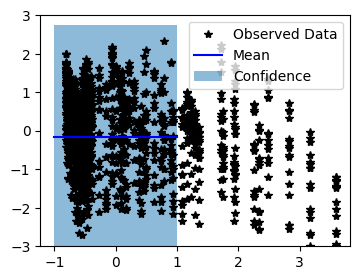

In [10]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x[:, 4].cpu().numpy(), train_y.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x_last.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x_last.cpu().numpy().flatten(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [12]:
observed_pred

MultivariateNormal(loc: torch.Size([101]))

In [55]:
lower.cpu()

tensor([-3.1232, -3.1181, -3.1130, -3.1080, -3.1030, -3.0982, -3.0936, -3.0893,
        -3.0852, -3.0814, -3.0780, -3.0751, -3.0726, -3.0706, -3.0692, -3.0685,
        -3.0683, -3.0689, -3.0702, -3.0722, -3.0749, -3.0783, -3.0825, -3.0874,
        -3.0930, -3.0993, -3.1061, -3.1135, -3.1214, -3.1296, -3.1382, -3.1471,
        -3.1561, -3.1652, -3.1742, -3.1832, -3.1919, -3.2004, -3.2086, -3.2164,
        -3.2238, -3.2307, -3.2371, -3.2429, -3.2483, -3.2530, -3.2573, -3.2610,
        -3.2642, -3.2670, -3.2693, -3.2713, -3.2729, -3.2742, -3.2753, -3.2762,
        -3.2769, -3.2775, -3.2781, -3.2787, -3.2793, -3.2799, -3.2806, -3.2814,
        -3.2824, -3.2835, -3.2847, -3.2861, -3.2876, -3.2893, -3.2911, -3.2930,
        -3.2950, -3.2970, -3.2991, -3.3013, -3.3034, -3.3054, -3.3075, -3.3094,
        -3.3111, -3.3128, -3.3142, -3.3155, -3.3165, -3.3172, -3.3177, -3.3179,
        -3.3179, -3.3175, -3.3168, -3.3158, -3.3146, -3.3130, -3.3112, -3.3091,
        -3.3067, -3.3041, -3.3013, -3.29

Text(0.5, 9.444444444444438, 'Frequency')

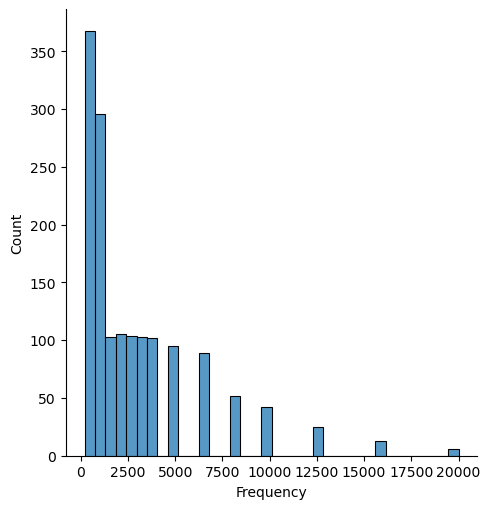

In [22]:
sns.displot(x[:, 0])
plt.xlabel("Frequency")

Text(0.5, 9.444444444444438, 'Angle')

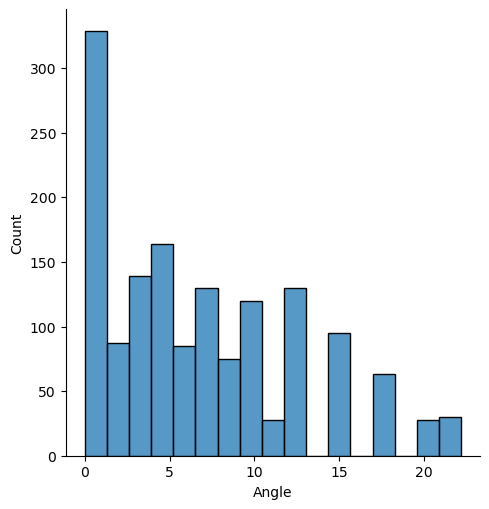

In [23]:
sns.displot(x[:, 1])
plt.xlabel("Angle")

Text(0.5, 9.444444444444438, 'Chord Length')

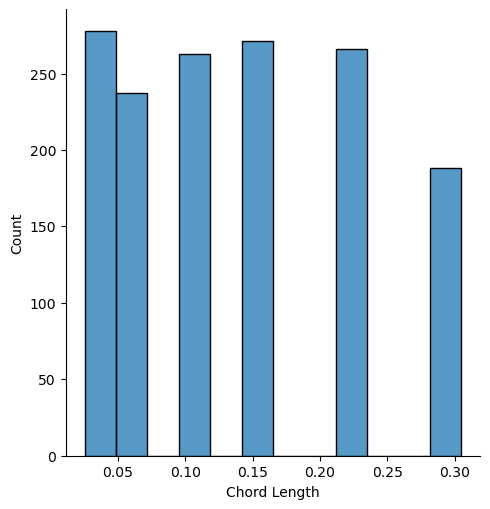

In [24]:
sns.displot(x[:, 2])
plt.xlabel("Chord Length")

Text(0.5, 9.444444444444438, 'Stream Velocity')

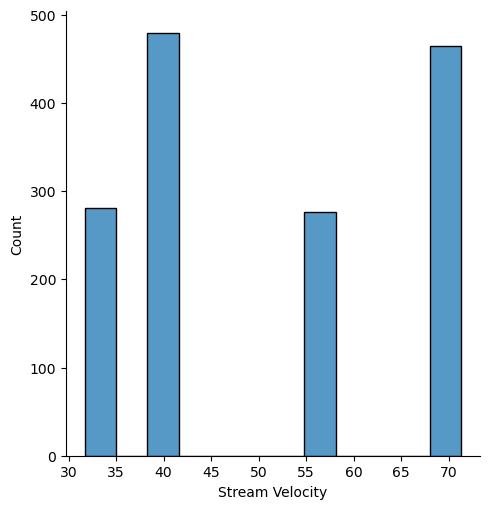

In [25]:
sns.displot(x[:, 3])
plt.xlabel("Stream Velocity")

Text(0.5, 9.444444444444438, 'Suction Side')

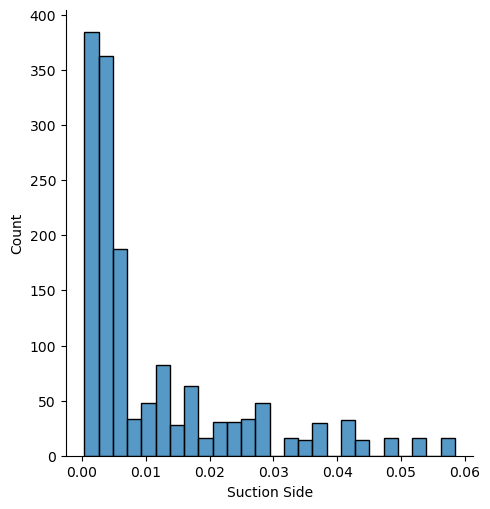

In [26]:
sns.displot(x[:, 4])
plt.xlabel("Suction Side")

Text(0.5, 9.444444444444438, 'Pressure Level (target)')

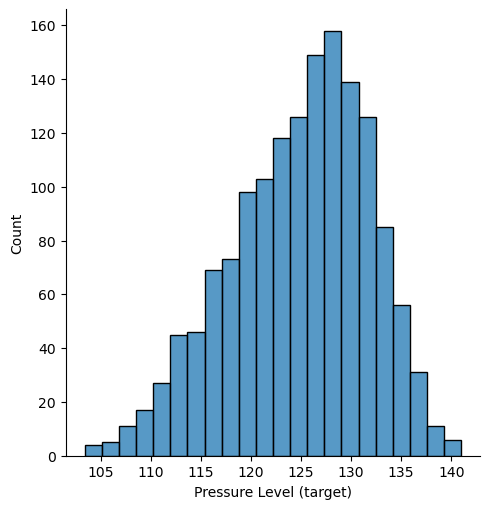

In [27]:
sns.displot(x[:, 5])
plt.xlabel("Pressure Level (target)")

In [12]:
scale= StandardScaler()

In [13]:
scaled_data = scale.fit_transform(x)

In [15]:
scale.mean_[-1]

124.83594278110434

In [17]:
scale.scale_[-1]

6.896361277488788

In [25]:
data_final = np.concatenate((scaled_data, np.expand_dims(x[:,5], axis = 1)), axis=1)

In [29]:
data_final.var(axis = 0)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       47.55979887])

In [31]:
scaled_data

array([[-0.6620227 , -1.14640293,  1.79929926,  1.31293526, -0.64480461,
         0.19793876],
       [-0.59856135, -1.14640293,  1.79929926,  1.31293526, -0.64480461,
         0.05293476],
       [-0.51923465, -1.14640293,  1.79929926,  1.31293526, -0.64480461,
         0.16168776],
       ...,
       [ 0.353359  ,  1.49044302, -0.37373954, -0.72334483,  3.17277251,
        -2.64370471],
       [ 0.67066578,  1.49044302, -0.37373954, -0.72334483,  3.17277251,
        -2.69880623],
       [ 1.08316459,  1.49044302, -0.37373954, -0.72334483,  3.17277251,
        -2.99171432]])

In [35]:
np.save("./data/airfoil_self_noise.npy", scaled_data)

In [3]:
x = np.load("./data/airfoil_self_noise.npy")

In [7]:
x.var(axis = 0)

array([1., 1., 1., 1., 1., 1.])